In [1]:
from scripts import setup_environment

setup_environment()

In [2]:
from scripts.dataset import BrainteaserDataset

dataset = BrainteaserDataset("data")

In [3]:
import string

from scripts.dataset import RiddleQuestion
from scripts.prompt_helpers import create_prompt_template


def args_generator(riddle_question: RiddleQuestion):
    template_args = {
        "question": riddle_question.question,
        "choices": "\n".join(
            [
                f"({string.ascii_uppercase[j]}) {choice}"
                for j, choice in enumerate(riddle_question.choice_list)
            ]
        ),
    }

    return template_args


chat_prompt_template = create_prompt_template("default")

In [4]:
from scripts.lmm import OllamaModelBuilder
from scripts.executor import Executor

base_url = "http://142.214.185.26:40001"
model_builder = OllamaModelBuilder(base_url)

executor = Executor(
    models=[
        # Llama3.1
        model_builder.build_model("llama3.1:8b-instruct-q8_0"),  # => 9 GB
        # Llama3.2
        model_builder.build_model("llama3.2:1b-instruct-fp16"),  # => 2.5 GB
        model_builder.build_model("llama3.2:3b-instruct-fp16"),  # => 6.4 GB
        # Phi3.5
        model_builder.build_model("phi3.5:3.8b-mini-instruct-fp16"),  # => 7.6 GB
        # Phi4
        model_builder.build_model("phi4:14b-q8_0"),  # => 16 GB
        # Qwen2.5
        model_builder.build_model("qwen2.5:0.5b-instruct-fp16"),  # => 1 GB
        model_builder.build_model("qwen2.5:1.5b-instruct-fp16"),  # => 3.1 GB
        model_builder.build_model("qwen2.5:3b-instruct-fp16"),  # => 6.2 GB
        model_builder.build_model("qwen2.5:7b-instruct-q8_0"),  # => 8.1 GB
        model_builder.build_model("qwen2.5:14b-instruct-q8_0"),  # => 16 GB
        model_builder.build_model("qwen2.5:32b-instruct-q4_K_M"),  # => 20 GB
        # Gemma2
        model_builder.build_model("gemma2:2b-instruct-fp16"),  # => 5.2 GB
        model_builder.build_model("gemma2:9b-instruct-q8_0"),  # => 9.8 GB
        model_builder.build_model("gemma2:27b-instruct-q4_K_M"),  # => 22 GB
        # Mistral Nemo
        model_builder.build_model("mistral-nemo:12b-instruct-2407-q8_0"),  # => 13 GB
    ]
)

2025-03-15 18:02:04,578 - INFO - Initialized executor with 15 models.


In [5]:
import numpy as np

from scripts.executor import Dataset

# Set fixed seed for reproducibility
np.random.seed(42)


def create_test_dataset(data: list[RiddleQuestion], name: str, percentage: float = 0.1):
    """Create a test dataset by randomly sampling a percentage of the original data."""
    indices = np.random.choice(
        len(data), size=int(len(data) * percentage), replace=False
    )
    return Dataset(name=name, riddles=[data[i] for i in indices])


# Create test datasets
sp_data = create_test_dataset(dataset.sp, "sp")
wp_data = create_test_dataset(dataset.wp, "wp")

# Prepare executor data
executor_data = [sp_data, wp_data]

In [6]:
import dill as pickle

# Get the best prompt type for each model
with open("results/best_system_prompts_by_model.pkl", "rb") as f:
    best_prompt_types = pickle.load(f)


def create_prompt_template_by_model(
    model_name: str,
    dataset_name: str,
):
    best_system_template_name = best_prompt_types[model_name][dataset_name][
        "prompt_type"
    ]
    return create_prompt_template(best_system_template_name)


def get_prompt_template(model_name: str, dataset: Dataset):
    # Split name after the b paramer, e.g., llama3.1:8b-instruct-fp16 => llama3.1:8b
    model_name = model_name[0 : model_name.index("b-") + 1]
    chat_prompt_template = create_prompt_template_by_model(model_name, dataset.name)
    return chat_prompt_template

In [7]:
for run_index in range(5):
    results = await executor.aexecute(
        executor_data,
        get_prompt_template,
        args_generator,
        dump_to_pickle=True,
        create_checkpoints=True,
        resume_from_checkpoint=True,
        run_name="model_speed",
        file_name_suffix=f"run_{run_index}",
    )

2025-03-15 18:02:04,604 - INFO - Starting execution 'model-speed with suffix 'run_0'': 2 dataset(s) x 15 model(s) = 1665 riddle evaluations


model-speed(run-0):   0%|          | 0/1665 [00:00<?, ?it/s]

TypeError: cannot unpack non-iterable WrappedResults object

## Eval results


defaultdict(dict,
            {'sp': {'llama3.1:8b-instruct-q8_0': 0.5064102611228621,
              'llama3.2:1b-instruct-fp16': 0.49276897755799165,
              'llama3.2:3b-instruct-fp16': 0.5489620046901499,
              'phi3.5:3.8b-mini-instruct-fp16': 3.806098730967438,
              'phi4:14b-q8_0': 1.660955219673821,
              'qwen2.5:0.5b-instruct-fp16': 1.5904337339619072,
              'qwen2.5:1.5b-instruct-fp16': 0.6588787048906194,
              'qwen2.5:3b-instruct-fp16': 2.8550495148385786,
              'qwen2.5:7b-instruct-q8_0': 0.9566603077045089,
              'qwen2.5:14b-instruct-q8_0': 1.1692109822716397,
              'qwen2.5:32b-instruct-q4_K_M': 2.481815384933559,
              'gemma2:2b-instruct-fp16': 1.2659985245678103,
              'gemma2:9b-instruct-q8_0': 0.7387370853914184,
              'gemma2:27b-instruct-q4_K_M': 1.4214350726245388,
              'mistral-nemo:12b-instruct-2407-q8_0': 0.9118791995603301},
             'wp': {'llama3.1:

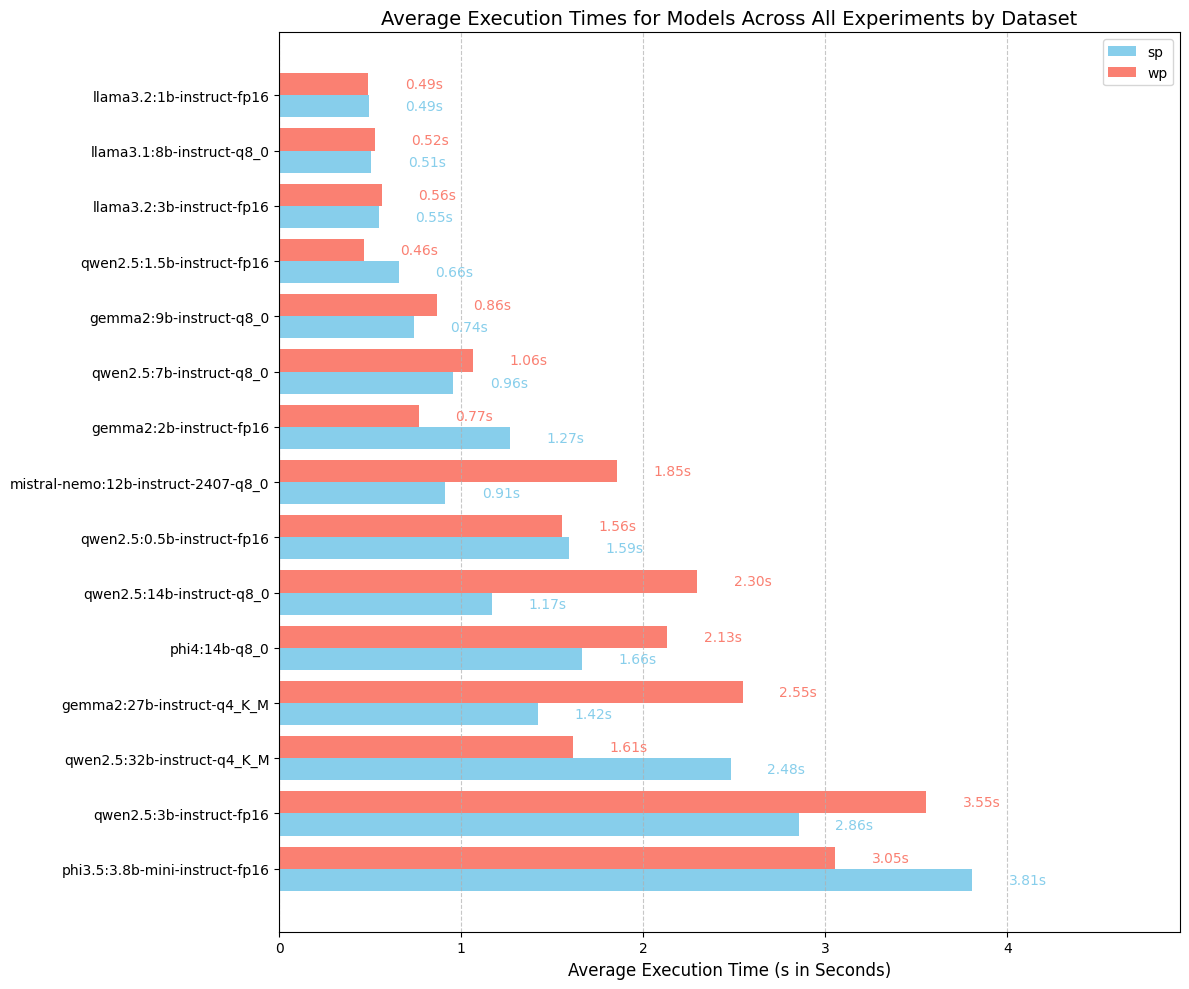

In [ ]:
import glob
from collections import defaultdict

import dill as pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scripts.executor import WrappedResults

# Find all result files from previous runs
result_files = glob.glob("results/*/*_results.pkl", recursive=True)

# Process the timing data from all result files
all_timing_data = defaultdict(lambda: defaultdict(list))

data = defaultdict(dict)
for result_file in result_files:
    with open(result_file, "rb") as f:
        wrapped_results: WrappedResults = pickle.load(f)

    for dataset, results in wrapped_results.results.items():
        for model_name, model_results in results.items():
            if (
                "fp16" not in model_name
                and "q8_0" not in model_name
                and "q4_K_M" not in model_name
            ):
                continue
            times = [x.get_execution_time() for x in model_results]
            if model_name not in data[dataset]:
                data[dataset][model_name] = []
            data[dataset][model_name].extend(times)

averages = defaultdict(dict)
for dataset, models in data.items():
    for model, times in models.items():
        avg = np.average(times)
        averages[dataset][model] = avg

data = averages
# Convert the nested dictionary to a DataFrame for easier plotting
df = pd.DataFrame()
for dataset, model_dict in data.items():
    temp_df = pd.DataFrame(list(model_dict.items()), columns=["model", "time"])
    temp_df["dataset"] = dataset
    df = pd.concat([df, temp_df], ignore_index=True)

# Pivot dataframe to have models as index and datasets as columns
pivot_df = df.pivot(index="model", columns="dataset", values="time").reset_index()

# Add combined time column for sorting
pivot_df["combined_time"] = pivot_df.sum(axis=1, numeric_only=True)
pivot_df = pivot_df.sort_values("combined_time", ascending=False)
pivot_df = pivot_df.drop("combined_time", axis=1)

# Create a single plot with both datasets
fig, ax = plt.subplots(figsize=(12, 10))

# Set width of bars
bar_width = 0.4
x = np.arange(len(pivot_df))

# Plot bars for each dataset
sp_bars = ax.barh(
    x - bar_width / 2, pivot_df["sp"], bar_width, label="sp", color="skyblue"
)
wp_bars = ax.barh(
    x + bar_width / 2, pivot_df["wp"], bar_width, label="wp", color="salmon"
)

# Add labels and title
ax.set_yticks(x)
ax.set_yticklabels(pivot_df["model"])
ax.set_xlabel("Average Execution Time (s in seconds)", fontsize=12)
ax.set_title(
    "Average Execution Times for Models Across All Experiments by Dataset", fontsize=14
)
ax.legend()

# Add time values at the end of each bar
for i, (sp_bar, wp_bar) in enumerate(zip(sp_bars, wp_bars, strict=False)):
    ax.text(
        sp_bar.get_width() + 0.2,
        sp_bar.get_y() + sp_bar.get_height() / 2,
        f"{pivot_df['sp'].iloc[i]:.2f}s",
        va="center",
        color="skyblue",
    )
    ax.text(
        wp_bar.get_width() + 0.2,
        wp_bar.get_y() + wp_bar.get_height() / 2,
        f"{pivot_df['wp'].iloc[i]:.2f}s",
        va="center",
        color="salmon",
    )

# Ensure there's enough space for the labels
ax.set_xlim(0, max(df["time"]) * 1.3)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("execution-times.pdf", format="pdf", bbox_inches="tight")

# Also display the original data for reference
display(data)